# Finetuning Transferable Pre-Trained Weights

In this notebook I walk through the benefits of using DINOv2 (Oquab et al., 2024) pre-trained encoder weights for finetuning on dense prediction tasks such as Image Segmentation. Combining good pre-trained weights with parameter-efficient finetuning (PEFT), such as Low-Rank Adaptation (Hu et al., 2021) (LoRA) allows models such as LLM to quickly finetune to specific tasks but also work in the vision domain. These methods add a small percentage (around 5-6%) of learnable parameters to the encoder, by inserting them between the encoder blocks and keeping the pre-trained weights frozen. In comparison to finetuning whole blocks in the encoder, finetuning only a small percentage of parameters and the decoder makes for shorter training times.

Below an example of three different scenarios for finetuning neural networks, for different downstream tasks. The most naive approach is to finetune just the decoder head which outputs the segmentation predictions in our scenario. The second approach is to also unfreeze some of the final encoder blocks to achieve better tuning to the downstream task. The third approach is by using LoRA to finetune the intermediate matrices A and B, and the decoder head.

<div style="text-align: center;">
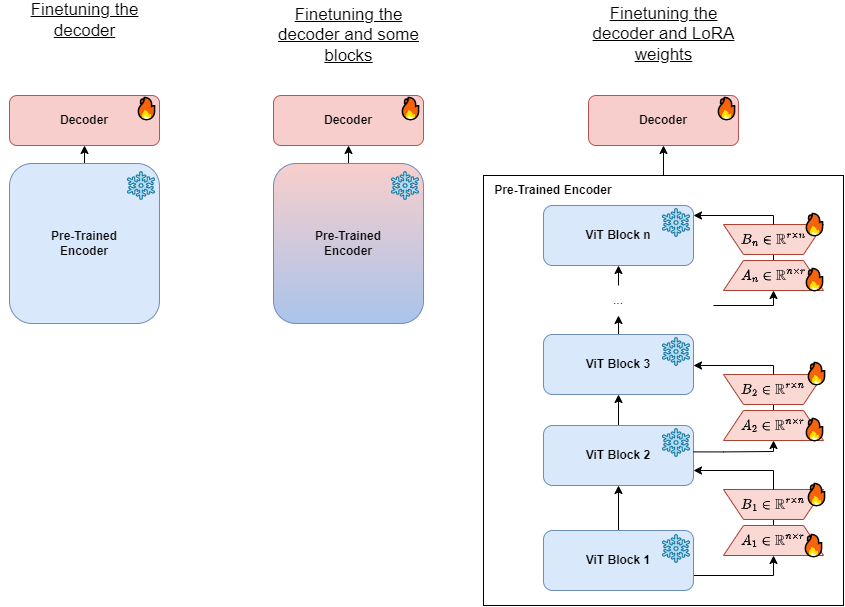
</div>

## Pre-Trained ViTs
Vision Transformer (ViT) (Dosovitskiy et al., 2021) models work by splitting an image into fixed-size patches, similar to tokens in NLP. Each patch is linearly embedded, combined with positional encodings, and then fed into a standard Transformer architecture. Unlike CNNs, which apply convolutional filters, ViTs process these patches using self-attention mechanisms to capture global relationships. This allows ViTs to effectively learn and represent the entire image context. The model's output is a class token that summarizes the information from all patches, which can then be used for classification. However, by changing out the head or decoder you can essentially use any downstream task.

<div style="text-align: center;">
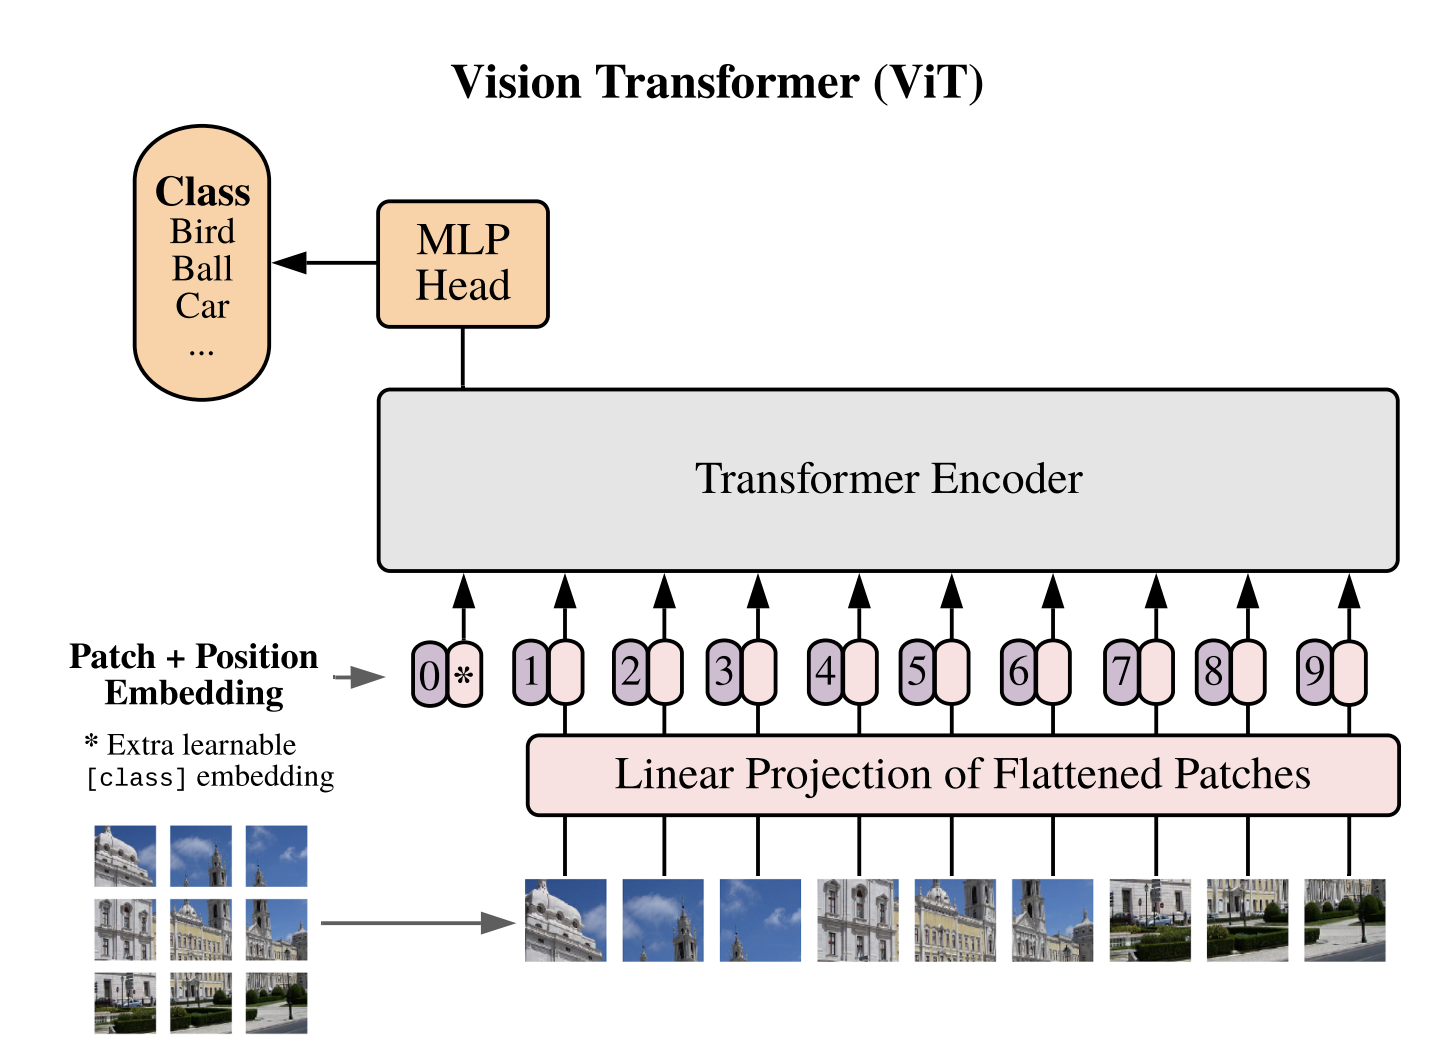
</div>

The first self-**di**stillation with **no** labels (DINO) method already used ViT in combination with self-supervised learning to learn strong pre-trained encoders. With the motivation to see similar successes in the vision domain, as self-supervised pretraining has in the natural language domain with models such as BERT, or GPT. In short, they use knowledge distillation in combination with a smart self-supervised (SSL) loss function that essentially pushes the network to cluster the embeddings based on content in the image. They notice that with pre-training ViT networks exhibit stronger performance in a number of benchmarks, such as image retrieval, video instance segmentation without any finetuning. As the heads in the ViT networks capture important features in the image (See example from the paper below).

<div style="text-align: center;">
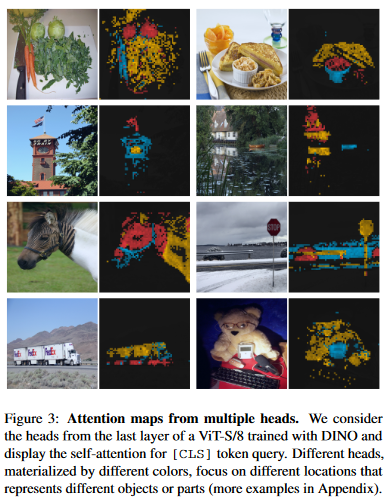
</div>

DINOv2 (Oquab et al., 2024) further improves the DINO by modifying many parts of the approach, but probably most importantly adding the idea of masked image modelling. This approach works by masking some of the input patches to the ViT network, and letting the network essentially predict what is in the masked parts of the image. This is speculated to be one of the most important additions to achieve good performance on downstream tasks such as image segmentation.

To demonstrate what features the encoder weights capture, we can recreate the popular example they show in the DINOv2 paper.

In [1]:
import glob

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Load a pre-trained ViT model
size = "large"

backbones = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
encoder = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=f"dinov2_{backbones[size]}").cuda()

patch_size = encoder.patch_size
patch_h, patch_w = 14*50//patch_size, 14*50//patch_size
background_threshold = 0.5

patch_size, patch_h

Using cache found in /home/rob/.cache/torch/hub/facebookresearch_dinov2_main


(14, 50)

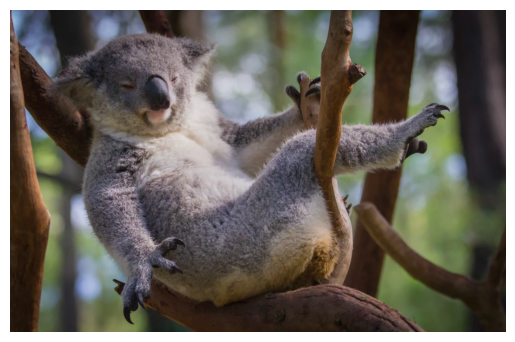

In [3]:
# For the example, I took a set of koalas
samples = glob.glob('assets/*.png')
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in samples]

plt.imshow(images[0])
plt.axis('off')
plt.show()

In [4]:
# pre-processing the image to pass it through the model; normalizing the input, and fitting
# it to required input size a multiple of the patch size.
def transform(img):
    img = cv2.resize(img, (patch_h * patch_size, patch_w * patch_size)) / 255
    img = (img - np.array([0.485, 0.456, 0.406]))/ np.array([0.229, 0.24, 0.225])
    img = img.transpose(2, 0, 1)
    return np.expand_dims(img, 0).astype(np.float32)

transformed_images = [transform(img) for img in images]

In [5]:
x = torch.tensor(np.concatenate(transformed_images)).cuda()

# Passing the input through the encoder
features_dict = encoder.forward_features(x)
features = features_dict['x_norm_patchtokens'].detach().cpu().numpy()
features.shape

(4, 2500, 1024)

In [6]:
patch_features = features.reshape(len(images) * patch_h * patch_w, -1)
patch_features.shape

(10000, 1024)

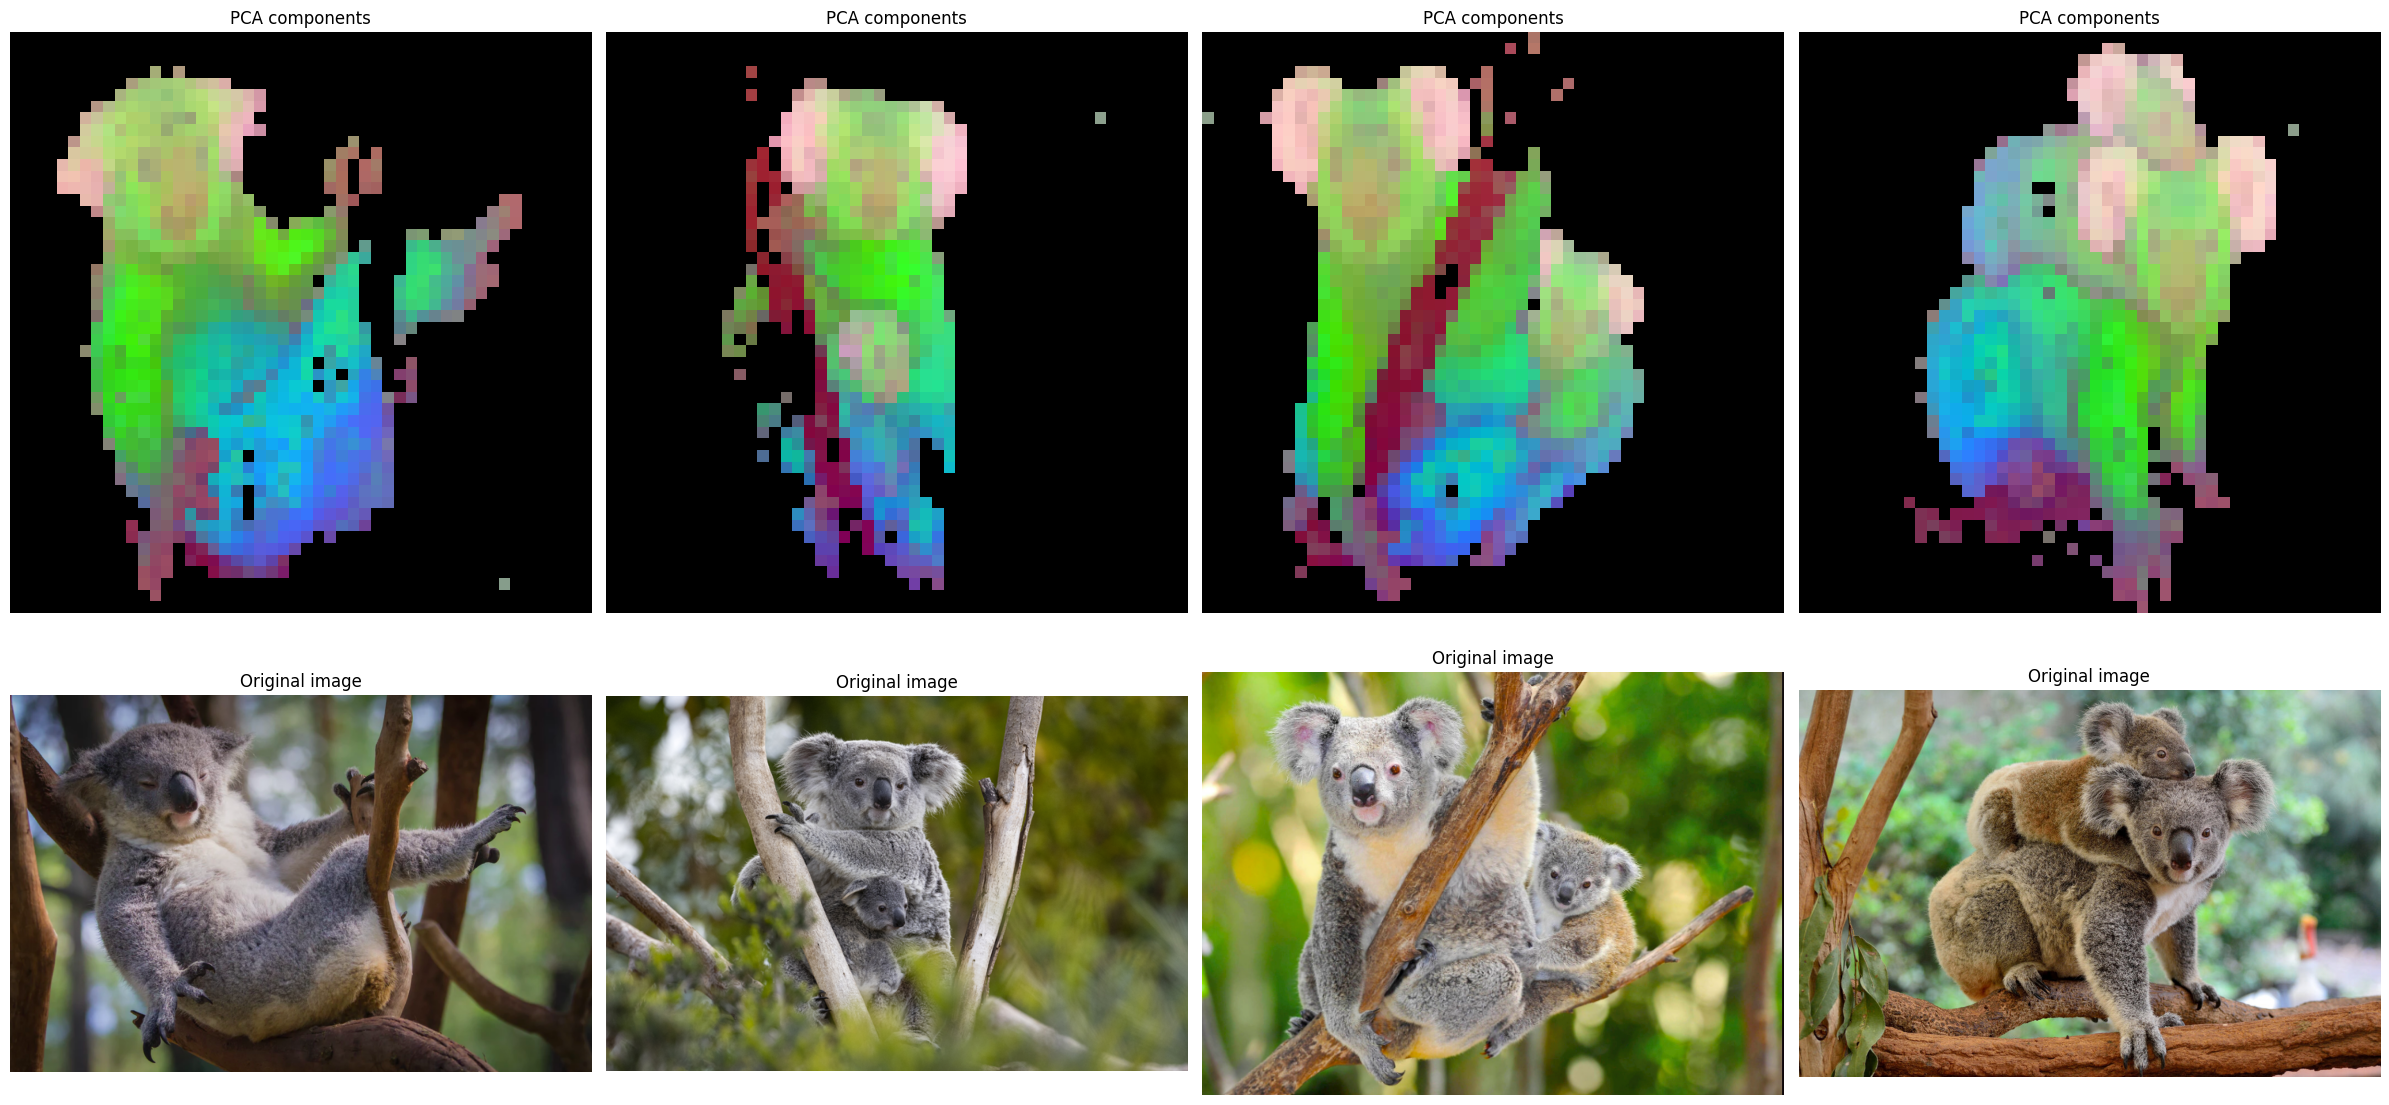

In [8]:
pca = PCA(n_components=3)
scaler = MinMaxScaler(clip=True)

# First fit to seperate background and foreground
pca.fit(patch_features)
pca_features = pca.transform(patch_features)

# MinMax Scaling
scaler.fit(pca_features)
pca_features = scaler.transform(pca_features)

pca_background = pca_features[:, 0] > background_threshold
pca_foreground = ~pca_background

# Second fit for the object
pca.fit(patch_features[pca_foreground])
pca_features_rem = pca.transform(patch_features[pca_foreground])

scaler.fit(pca_features_rem)
pca_features_rem = scaler.transform(pca_features_rem)

pca_features_rgb = np.zeros((len(images) * patch_h * patch_w, 3))
pca_features_rgb[pca_background] = 0
pca_features_rgb[pca_foreground] = pca_features_rem
pca_features_rgb = pca_features_rgb.reshape(len(images), patch_h, patch_w, 3)


fig, axes = plt.subplots(2, len(images), figsize=(6 * len(images), 12))

for i in range(len(images)):
    axes[0, i].imshow(pca_features_rgb[i])
    axes[0, i].set_title(f'PCA components')
    axes[0, i].axis('off')

    # Plot original images
    axes[1, i].imshow(images[i])
    axes[1, i].set_title(f'Original image')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Interesting here is that parts of the features which are semantically similar are also captured as such by the model, for example all the ears in the model have roughly the same colour in the PCA RGB component space.

## LoRA Finetuning Comparison

So, to finally introduce LoRA the idea behind it is very simple. Instead of finetuning the entire model, we introduce this small set of weights inbetween every block defined by $A_i \in \mathbb{R}^{r \times n}$ and $B_i \in \mathbb{R}^{n \times r}$ multiplying these layers we will get $\Delta W_i = B_iA_i$. Moreover, we determine the size of these layers by setting a value for rank $r$, usually $r <\!\!< min(d, k)$. 

Then, during training we freeze the original ViT block and add our weight $\Delta W_i$, ViT_block $h_i$, becomes, 
$$
h_i = W_i x + \Delta W_i x.
$$
where $W_i$ are the original weights and we apply this to every block of the encoder. 


TODO: Show benefits of finetuning with LoRA

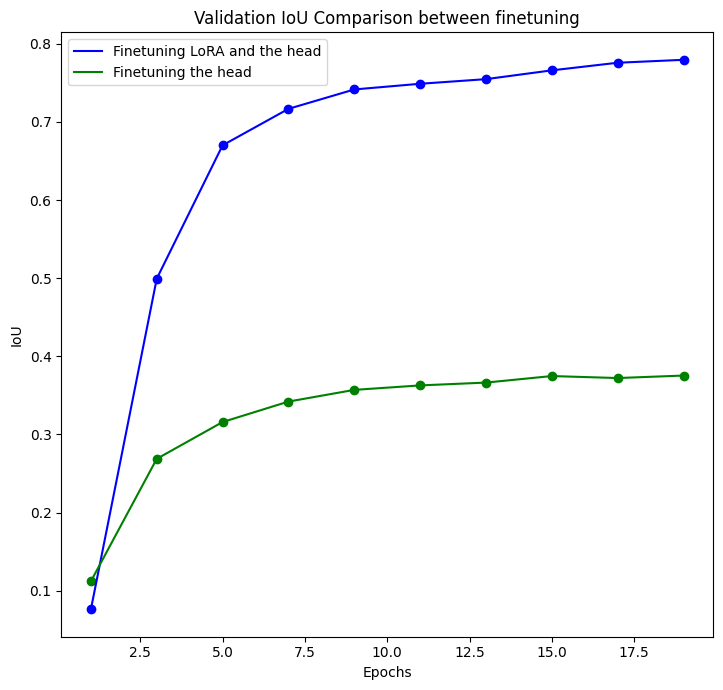

In [16]:
import json

def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

lora_val_iou = load_json('output/lora_metrics.json')['val_iou']
baseline_val_iou = load_json('output/baseline_metrics.json')['val_iou']

lora_epoch = range(1, 20, 2)
baseline_epoch = range(1, 20, 2)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 2)
plt.plot(lora_epoch, lora_val_iou, 'b-', label='Finetuning LoRA and the head')
plt.scatter(lora_epoch, lora_val_iou, c='blue')
plt.plot(baseline_epoch, baseline_val_iou, 'g-', label='Finetuning the head')
plt.scatter(baseline_epoch, baseline_val_iou, c='green')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Validation IoU Comparison between finetuning')
plt.legend()

plt.tight_layout()
plt.show()


## Transfer and Adaptation

These types of pre-trained models with self-supervised learning show to have good robustness, when corrupting a dataset such as imageNet and using the output of the encoder directly with a linear classification head they show exceptional robustness.

TODO: Add experiments

## References
Oquab, M., Darcet, T., Moutakanni, T., Vo, H., Szafraniec, M., Khalidov, V., Fernandez, P., Haziza, D., Massa, F., El-Nouby, A., Assran, M., Ballas, N., Galuba, W., Howes, R., Huang, P.-Y., Li, S.-W., Misra, I., Rabbat, M., Sharma, V., … Bojanowski, P. (2024). DINOv2: Learning Robust Visual Features without Supervision (arXiv:2304.07193). arXiv. http://arxiv.org/abs/2304.07193

Darcet, T., Oquab, M., Mairal, J., & Bojanowski, P. (2024). Vision Transformers Need Registers (arXiv:2309.16588). arXiv. https://doi.org/10.48550/arXiv.2309.16588

Caron, M., Touvron, H., Misra, I., Jégou, H., Mairal, J., Bojanowski, P., & Joulin, A. (2021). Emerging Properties in Self-Supervised Vision Transformers (arXiv:2104.14294). arXiv. https://doi.org/10.48550/arXiv.2104.14294

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2021). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (arXiv:2010.11929). arXiv. https://doi.org/10.48550/arXiv.2010.11929